# MC886 - Projeto 1
Aluno: Mateus Feitosa Olivi  RA: 222059

# Parte 1:
    
<p style="text-align: justify;">
&emsp;Na primeira parte deste projeto o objetivo é implementar o algoritmos K-means e um outro algoritmo de aprendizado não supervisionado, no meu caso escolhi o Hierarchical Clustering. Após serem implementados o objetivo será analisar o comportamento dos algoritmos para diferentes valores de K, além de descobrir o melhor valor, também irei analisar o efeito da normalização dos dados de entrada, o efeito do inicialização dos centroides e tentar analisar qual dos algoritmos é o mais indicado para esse conjunto de dados

### 1. K-Means:
&emsp;O K-Means é um algoritmo de aprendizado não supervisionado, que faz a clusterização dos dados de entrada de acordo com suas características.<br>
&emsp;O algoritmo é bem simples, para fazer a clusterização basta que se execute os passos abaixo:
1. Definir um valor de K, ou seja, um número de clusters.
2. Inicializar os centroide para cada cluster.
3. Definir os clusters de cada ponto, o cluster que cada ponto pertence é referente ao centróide mais próximo, em termos de distancia euclidiana.
4. Reposicionar o centróide. A nova posição do centroide deve ser a média da posição de todos os pontos do cluster.
5. Repetir 3 e 4 até que os centróides não varie.
</p>

### 1.1 Implementação
<p style="text-align: justify;">&emsp;Inicialmente preciso fazer a leitura dos dados bem como sua normalização, para isso usarei a biblioteca pandas. A normalização utilizada será a Min-Max.<br>
&emsp;A minha função contará com um parametro "norm", caso esse seja true então a normalização será aplicada, optei por esse parametro porque mais a frente irei analisar o impacto da normalização.<br>
&emsp; Essa função também faz o split do dataset no dataset de traino e de teste, para pegar dados ao logo de todo dataset original eu fiz a seguinte divisão:</p>
<p style="text-align: center;"> | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste |</p>
<p style="text-align: justify;">&emsp;Totalizando em 90% do dataset como treinamento e 10% como teste. O parametro dataset da função que irá definir se o dataset de treino ou de teste que será retornado, para isso basta passar como parametro as strings 'training' ou 'test'.</p>

In [100]:
import pandas as pd
from math import floor, ceil

def Dados(caminho, dataset = 'training', norm = True):
    X = pd.read_csv(caminho, sep = ' ', header = None)
    if(norm):
        X = (X-X.min())/(X.max()-X.min()) # Min-Max
        
    training, test = [], []
    Total = len(X)
    
    for i in range(5):
        training.append(X.head(floor(Total*0.18)))
        X = X.iloc[floor(Total*0.18):]
        test.append(X.head(ceil(Total*0.02)))
        X = X.iloc[ceil(Total*0.02):]
    
    training = pd.concat(training)
    test = pd.concat(test)
    
    if(dataset == 'training'):
        return training.values
    elif(dataset == 'test'):
        return test.values

&emsp;Agora irei implementar a inicialização dos clusters e dos centroides.<br>
&emsp;O conjunto de clusters estara representado por um dicionario, cada chave desse dicionario referenciará um cluster diferente e cada cluster tem um conjunto de arrays que representam os pontos.<br>
&emsp;Os centroides serão inicializados utilizando o metódo Forgy, ou seja, para k clusters irão ser escolhidos k pontos aleatórios, pertecentes aos dados, para serem os centroides iniciais.

In [101]:
import numpy as np
import random as rd

def inicializaCluster(k):
    clusters = {}
    for i in range(k):
        clusters[i] = []
    return clusters

def inicializaCentroides(X,k):
    aux = X.tolist()
    centroides = rd.sample(aux, k)
    centroides = np.array(centroides)
    return centroides

&emsp;Já tendo preparado a inicialização dos clusters e dos centroides, agora preciso implementar as funções para definir os clusters e calcular a posição dos centroides.<br>
&emsp;Para se definir os clusters é medido a distancia entre os pontos e os centroides, então os pontos são definidos ao clusters cuja o centroide é o mais próximo.<br>
&emsp;Já os centroides são calculados sabendo que a nova posição do centroide deve ser a média da posição de todos os pontos do cluster.

In [102]:
def defineClusters(X, centroids, k):
    clusters = inicializaCluster(k) 
    for data in X:
        distancias = []
        for i in range(k):
            distancia = np.linalg.norm(data - centroids[i])
            distancias.append(distancia)
        clusters[distancias.index(min(distancias))].append(data)
    return clusters

def calculaCentroides(centroides, clusters, k):
    novo = cp.deepcopy(centroides)
    for i in range(k):
        novo[i] = np.average(clusters[i], axis=0)
    return novo

&emsp; Agora basta aplicar o algoritmo apresentado no inicio da explicacao e se obtém o seguinte código:

In [103]:
import copy as cp

def kmeans(X, k):
    centroides_anterior = inicializaCentroides(X,k)
    erro = 1
    while erro != 0:
        clusters = defineClusters(X, centroides_anterior, k)
        centroides_novo = calculaCentroides(centroides_anterior, clusters, k)
        erro = np.linalg.norm(centroides_novo - centroides_anterior)
        centroides_anterior = cp.deepcopy(centroides_novo)
    return clusters, centroides_novo 

&emsp; Pronto, o k-means foi finalizado, mas antes de aplica-lo para treinamento, vou implementar um método para achar o melhor valor para k.<br>
&emsp; O método a ser implementado será o método "elbow", o método do cotovelo, esse método consiste em plotar um gráfico com K Clusters vs Distorção, sendo a distorção a soma do quadrado das distancias entre os pontos do cluster e o centroide. <br>
&emsp;Após plotado o gráfico, deve se identificar uma mudança de comportamento no gráfico (cotovelo), que indica nosso melhor valor de K.<br>

In [104]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

def elbow(X):
    Grafico = []
    for k in range(1,10):
        Sum = 0
        clusters, centroides = kmeans(X, k)
        for i in range(len(clusters)):
            for j in range(len(clusters[i])):
                distancia = np.linalg.norm(clusters[i][j] - centroides[i])
                Sum += distancia**2
        Grafico.append([k,Sum])
    Grafico = np.array(Grafico)
    
    plt.plot(Grafico[:,0],Grafico[:,1], 'bx-')
    plt.xticks(Grafico[:,0])
    plt.xlabel('Valor de K')
    plt.ylabel('Distorção')
    plt.title('Método Elbow')
    plt.show()

### 1.2 Execução

&emsp;Inicialmente eu irei fazer a leitura dos dados, pegando os dados de treinamento (90% dos dados, explicado no primeiro tópico) e em seguida aplicar o método elbow, através da função elbow

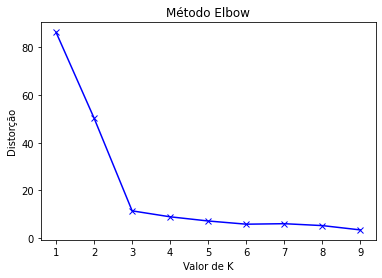

In [105]:
X = Dados('cluster.dat', dataset = 'training', norm = True)
elbow(X)

&emsp; Visivelmente, pelo método elbow, a melhor maneira para se clusterizar os dados são utilizando k = 3 clusters, com isso em mente, irei executar a função kmeans para k = 3:

In [106]:
X = Dados('cluster.dat', dataset = 'training', norm = True)
clusters, centroides = kmeans(X,k = 3)

&emsp; O código executou sem erros, agora vou fazer um código bem simples para mostrar o resultado da clusterizacao e ver se realmente o algoritmo produziu algo que faz sentido

In [107]:
def kmeansplot(clusters, centroides):
    cores = ['r','b','g','c','m','y']
    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        plt.scatter(cluster[:,0] , cluster[:,1], s=75, color=cores[i],  edgecolor='k',label='cluster '+str(i+1))

    plt.scatter(centroides[:, 0], centroides[:, 1], s=300, marker='*',c='yellow', edgecolor='k',label='centroides')
    plt.legend(scatterpoints=1)
    plt.show()

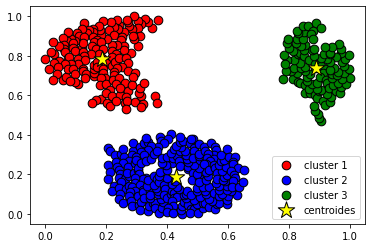

In [108]:
kmeansplot(clusters, centroides)

&emsp; Aparentemente o algoritmo elbow nos deu um valor ótimo de k, pois visualmente é possivel notar que a clusterização foi ótima e os clusters estão muito bem definidos.

### 1.3 Analise
&emsp;Neste tópico farei a análise do efeito da normalização e da inicialização do centróide.

#### 1.3.1 Normalização
&emsp; Inicialmente irei fazer a analise do efeito da normalização sobre a clusterização do k-means, para isso eu irei atribuir os dados de entrada, sem aplicar a normalização, à variavél X2.<br>
&emsp; Após isso irei executar a função elbow e plotar o gráfico para o kmeans, então irei analisar as diferenças entre a clusterização com e sem a normalização.

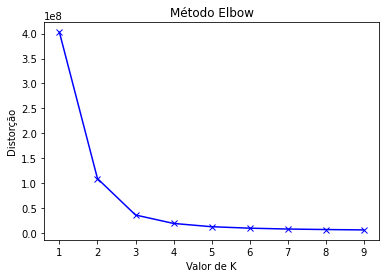

In [109]:
X2 = Dados('cluster.dat', dataset = 'training', norm = False)
elbow(X2)

&emsp; O método elbow, para esse caso, parece ser inconclusivo, porém como sabemos que para esses dados k = 3, vou aplicar o kmeans para esse k:

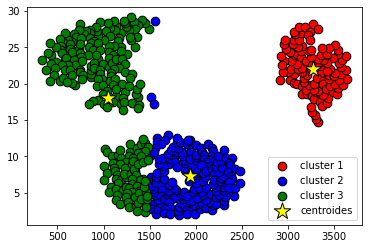

In [110]:
clusters2, centroides2 = kmeans(X2,k = 3)
kmeansplot(clusters2, centroides2)

&emsp; É possível notar que a clusterização ficou errada, mas isso já era de se esperar, como estamos trabalhando com distâncias euclidianas a escala das features importam muito, isso por que a diferença nas escalas das features implica em uma diferença na importancia das features para o kmeans. <br>
&emsp; Esse efeito fica evidente no gráfico acima, a escala do eixo y é 100 vezes menor que a do eixo x, então é natural que os pontos fossem clusterizados em setores verticais, visto que os pontos do gráfico estão 100 vezes mais próximos em y do que em x.<br>
&emsp; Para demonstrar o que estou dizendo, vou plotar novamento o gráfico, mas agora irei colocar a escala do eixo y próxima a escala do eixo x, mas sem alterar a escala dos dados:

In [111]:
def kmeansplot_2(clusters, centroides):
    cores = ['r','b','g','c','m','y']
    plt. ylim(1, 1500)
    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        plt.scatter(cluster[:,0] , cluster[:,1], s=75, color=cores[i] ,label='cluster '+str(i+1))

    plt.scatter(centroides[:, 0], centroides[:, 1], s=300, marker='*',c='yellow',label='centroides')
    plt.legend(scatterpoints=1)
    plt.show()

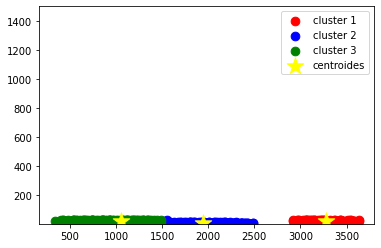

In [112]:
kmeansplot_2(clusters2, centroides2)

&emsp; É desse modo que o kmeans está enxergando os dados, e agora fica muito mais intuitivo perceber o motivo do kmeans ter clusterizado o gráfico dessa forma, como a escala do eixo x dos dados é muito maior, o kmeans enxerga muita pouca diferença entre os valores de y, o que é evidente no gráfico plotado acima.<br>
&emsp; Assim, a normalização é de extrema importancia, pois ao faze-la garantimos que o mesmo peso e importancia sejam dadas a todas as features.

#### 1.3.2 Inicialização dos centroides
&emsp;Outro aspecto que deve ser analisado é a inicialização dos centroides, dependendo da posição de início o kmeans pode acabar caindo em um mínimo local e não conseguirá prosseguir com a clusterização.<br>
&emsp; No algoritmo do kmeans que eu usei, apliquei o inicilização do tipo Forgy, ou seja, ele escolherá como centroide k pontos pertencentes ao cojunto de dados normalizado. Para verificar o impacto desse método Forgy, modificarei o kmeans para imprimir o número de iterações, e aplicarei o kmeans em um loop com 20 execuções, assim poderemos ter uma noção melhor do que está acontecendo:

In [113]:
def kmeans2(X, k):
    centroides_anterior = inicializaCentroides(X,k)
    erro = 1
    i = 0
    while erro != 0:
        clusters = defineClusters(X, centroides_anterior, k)
        centroides_novo = calculaCentroides(centroides_anterior, clusters, k)
        erro = np.linalg.norm(centroides_novo - centroides_anterior)
        centroides_anterior = cp.deepcopy(centroides_novo)
        i+= 1
    print(" - "+str(i) + " iterações")
    return clusters, centroides_novo

In [114]:
X = Dados('cluster.dat', dataset = 'training' ,norm = True)
for i in range(20):
    print("Execução " + str(i), end = ' ')
    clus, cent = kmeans2(X, 3)

Execução 0  - 9 iterações
Execução 1  - 5 iterações
Execução 2  - 7 iterações
Execução 3  - 4 iterações
Execução 4  - 3 iterações
Execução 5  - 3 iterações
Execução 6  - 4 iterações
Execução 7  - 3 iterações
Execução 8  - 3 iterações
Execução 9  - 5 iterações
Execução 10  - 5 iterações
Execução 11  - 3 iterações
Execução 12  - 5 iterações
Execução 13  - 4 iterações
Execução 14  - 2 iterações
Execução 15  - 5 iterações
Execução 16  - 4 iterações
Execução 17  - 4 iterações
Execução 18  - 5 iterações
Execução 19  - 23 iterações


&emsp; O resultado acima nos mostra como o número de iterações pode variar baseado na inicialização, note que, para esse exemplo, tivemos inicializações que levaram o kmeans a ter de 2 até 23 iterações.<br>
&emsp; O número de iterações não é o único problema que podemos ter, como dito anteriormente, dependendo da inicialização o kmeans pode cair em minimos locais. Para mostrar esse efeito vou modificar a minha função kmeans para que um dos parametros seja a inicialização do centroide e assim possamos fazer alguns testes:

In [115]:
def kmeans3(X, k, centroide_inicial):
    centroides_anterior = centroide_inicial
    erro = 1
    while erro != 0:
        clusters = defineClusters(X, centroides_anterior, k)
        centroides_novo = calculaCentroides(centroides_anterior, clusters, k)
        erro = np.linalg.norm(centroides_novo - centroides_anterior)
        centroides_anterior = cp.deepcopy(centroides_novo)
    return clusters, centroides_novo

&emsp; Do conjunto de dados normalizados achei uma inicialização que leva a um minimo local, vamos ver o resultado do kmeans:

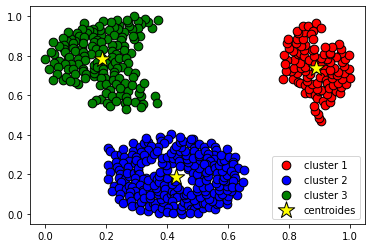

In [116]:
centroide_1 = np.array([[0.15151515,0.80698529],[0.52272727,0.33823529],[0.04090909,0.74080882]])

clus, cent = kmeans3(X,3,centroide_1)
kmeansplot(clus, cent)

<p style="text-align: justify;">
&emsp; Eu obtive essa inicialização executando o kmeans com a inicialização Forgy varias vezes até achar uma inicialização problematica, e acima podemos ver que a clusterização ficou totalmente errada, então assim pode-se notar que mesmo a inicialização Forgy está suscetível a erros, o que reforça a ideia de que devemos executar o kmeans mais de uma vez para ter certeza que obtivemos uma boa clusterização.<br>
&emsp; Pode-se,também, ter problemas com a escolha de inicializações em que os pontos estão distante do conjuntos de dados, podendo levar a ter clusters vazios ou então um alto número de iterações para se obter convergencia.<br>
&emsp; É dito que a melhor inicialização que tem é a do kmeans++, pois ele garante uma maior distribuição dos centroides dentro do conjunto de dados.
</p>

### 1.4 Aplicação do conjunto de testes
<p style="text-align: justify;">
    &emsp; Agora chegou o momento de classificar os pontos do conjunto de testes, para melhor organização irei fazer novamente o treinamento (utilizando o conjunto de treinamento) com as funções ja prontas e a após isso irei utilizar os centroides que foi obtido pelo kmeans para determinar a qual cluster os pontos do conjunto de teste pertencem.
</p>

#### 1.4.1 Treinamento
&emsp; O Treinamento é simples, basta executar as funções já prontas, lembrando que,baseado em toda analise anterior, aplicaremos o k-means para k = 3:

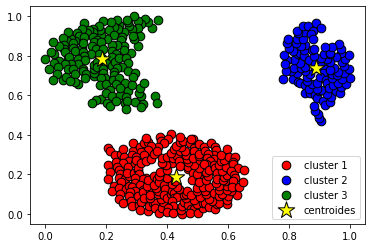

In [137]:
TrainingDataset = Dados('cluster.dat', dataset = 'training', norm = True)
clustersTreino, centroides = kmeans(X,k = 3)
kmeansplot(clustersTreino, centroides)

#### 1.4.2 Definição dos clusters do conjunto de testes
<p style="text-align: justify;">
&emsp; O Treinamento foi completo, e o que importa pra nós é a posição dos centroides, isso por que iremos definir os clusters do conjunto de testes baseado nas distancias dos centroides, em outras palavras, um ponto fará parte do cluster cujo centroide está mais próximo.<br>
&emsp; Mas primeiro preciso fazer uma função bem simples que defina o cluster baseando-se na posição dos centroides:
</p>

In [175]:
def defineCluster(centroide, testDataset):
    clusterTest = inicializaCluster(len(centroide))
    for i in range(len(testDataset)):
        for j in range(len(testDataset[i])):
            indiceMenor = 0
            distanciaAnterior = -1
            for k in range(len(centroide)):    
                distancia = np.linalg.norm(testDataset[i] - centroide[k])
                if(distanciaAnterior < 0 or distancia < distanciaAnterior):
                    indiceMenor = k
                    distanciaAnterior = distancia
            clusterTest[indiceMenor].append(testDataset[i])
    return clusterTest

In [189]:
testDataset = Dados('cluster.dat', dataset = 'test', norm = True)
clusterTestData =  defineCluster(centroides, testDataset)

Os clusters foram definidos, agora vamos plotar os centroides e os clusters obitido do conjunto de teste

In [215]:
def plotTest(clusters, centroides):
    cores = ['r','b','g','c','m','y']
    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        plt.scatter(cluster[:,0] , cluster[:,1], s=75, color=cores[i],  edgecolor='k',label='cluster '+str(i+1))
    
    
    plt.scatter(centroides[:, 0],centroides[:, 1],s=300,marker='*', c='yellow', edgecolor='k',label='centroides')

    plt.legend(scatterpoints=1)
    plt.show()

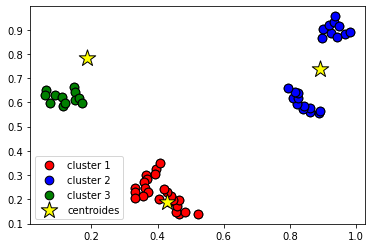

In [216]:
plotTest(clusterTestData, centroides)

<p style="text-align: justify;">
&emsp; Pode-se ver que os dados do conjunto de teste foram bem classificados e portanto o método do kmeans foi uma boa alternativa para fazer o treinamendo dos pontos do conjunto de treinamento .<br>
</p>

### 2. Agglomerative Hierarchical Clustering
&emsp;O Agglomerative Hierarchical Clustering é um método de clusterização que visa construir uma hierarquia de clusters. Neste método, inicialmente todo ponto é considerado um cluster, a medida que o algoritmo prossegue os clusters proximos sofrem merge e assim vão subindo na hierarquia.<br>
&emsp;Para fazer a clusterização basta que se execute os passos abaixo:
1. Fazer uma matriz de proximidade.
2. Fazer o merge de dois clusters próximos.
3. Atulizar a matriz de proximidade, mostrando que ja foi feito o merge desses clusters ou que um novo cluster surgiu.
4. Repetir 2 e 3 até sobre apenas 1 cluster.

&emsp;No meu caso, no o passo 4, o algoritmo irá rodar até obter um número de k clusters e todo elemento ter sido atribuido a um cluster diferente.

### 2.1 Implementação
Primeiro vou fazer todos os imports necessarios:

In [117]:
from scipy.spatial import distance_matrix
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt
%matplotlib inline

&emsp;Para fazer a leitura dos dados irei usar a mesma função que usei para o algoritmo do kmeans, lembre-se que o algoritmo faz a seguinte divisão do dataset:
<p style="text-align: center;"> | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste |</p>

In [96]:
def Dados(caminho, dataset = 'training', norm = True):
    X = pd.read_csv(caminho, sep = ' ', header = None)
    if(norm):
        X = (X-X.min())/(X.max()-X.min()) # Min-Max
        
    training, test = [], []
    Total = len(X)
    
    for i in range(5):
        training.append(X.head(floor(Total*0.18)))
        X = X.iloc[floor(Total*0.18):]
        test.append(X.head(ceil(Total*0.02)))
        X = X.iloc[ceil(Total*0.02):]
    
    training = pd.concat(training)
    test = pd.concat(test)
    
    if(dataset == 'training'):
        return training.values
    elif(dataset == 'test'):
        return test.values
    

&emsp; Agora farei funções auxiliares para simplificar o processo da clusterização hierarquica:
1. achaCluster: dado um ponto e o conjunto de clusters, essa função retorna a chave do cluster a qual esse ponto pertence, senão retorna -1
2. mergeClusters: dado a chave de dois clusters, essa função faz merge desses dois clusters 
3. newCluster: dado  dois pontos e o conjunto de clusters, essa função adiciona esses dois pontos a um novo clusters

In [118]:
def achaCluster(ponto,clusters):
    for key in clusters:
        for pos in range(len(clusters[key])):
            if(clusters[key][pos] == ponto):
                return key
    return -1

def mergeClusters(clus, keyA, keyB):
    clusters = cp.deepcopy(clus)
    for i in range(len(clusters[keyB])):
        clusters[keyA].append(clusters[keyB][i])
    clusters.pop(keyB)
    return clusters

def newCluster(clusters, PontoA, PontoB):
    i = len(clusters)
    keys = clusters.keys()
    while(True):
        if(i not in keys):
            clusters[i] = [PontoA,PontoB]
            break
        i += 1
    return clusters

&emsp;Agora, finalmente, vou aplicar o algoritmo do Hierarchical Clustering, note que essa função retorna o conjunto de clusters, porém o conteúdo dentro dos clusters não são os pontos e sim suas respectivas posições dos dados, assim precisei fazer uma função converte, que substitui a posição dos pontos pelos seus respectivos pontos.

In [119]:
def converte(clusters, dados):
    resultado = {}
    j = 0
    for key in clusters:
        resultado[j] = []
        for i in range(len(clusters[key])):
            resultado[j].append(dados[clusters[key][i]])
        j+= 1
    return resultado

def Hierarquico(X, k):
    dados = X.tolist()
    matrix = np.triu(distance_matrix(dados,dados))

    clusters = {}
    tamanho = 0
    while(len(clusters) > k or tamanho != len(dados)):
        Indice_min = np.where(matrix == np.min(matrix[np.nonzero(matrix)]))
        PontoA = Indice_min[0][0]
        PontoB = Indice_min[1][0]
    
        keyA = achaCluster(PontoA, clusters)
        keyB = achaCluster(PontoB, clusters)
        if(keyA == -1 and keyB == -1):
            clusters = newCluster(clusters, PontoA, PontoB)
        elif(keyA == -1):
            if(PontoA not in clusters[keyB]):
                clusters[keyB].append(PontoA)
        elif(keyB == -1):
            if(PontoB not in clusters[keyA]):
                clusters[keyA].append(PontoB)
        else:
            if(keyA != keyB):
                clusters = mergeClusters(clusters, keyA, keyB)
        
        matrix[PontoA][PontoB] = 0
        tamanho = sum(len(cluster) for cluster in clusters.values())
    clusters = converte(clusters, dados)
    return clusters

### 2.2 Execução
&emsp;Para a execução precisarei descobrir o número ideal de clusters, no kmeans usei o método elbow para isso, porém o método elbow exige os centroides para definir o número k, como o hierarchical cluster não nos da centroides irei usar a média aritimétida dos pontos do cluster no lugar do centroide.<br>

In [120]:
def elbowHierarchical(X):
    Grafico = []
    for k in range(1,9):
        Sum = 0
        media = []
        clusters = Hierarquico(X, k)
        for i in range(len(clusters)):
            media.append(np.average(clusters[i], axis=0))
        for i in range(len(clusters)):
            for j in range(len(clusters[i])):
                distancia = np.linalg.norm(clusters[i][j] - media[i])
                Sum += distancia**2
        Grafico.append([k,Sum])
    Grafico = np.array(Grafico)
    
    plt.plot(Grafico[:,0],Grafico[:,1], 'bx-')
    plt.xticks(Grafico[:,0])
    plt.xlabel('Valor de K')
    plt.ylabel('Distorção')
    plt.title('Método Elbow')
    plt.show()

Executando o código acima temos:

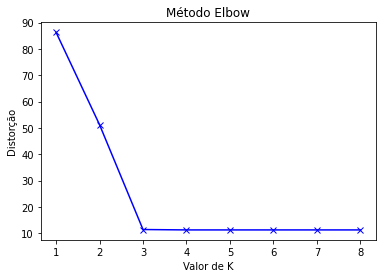

In [129]:
X = Dados('cluster.dat', dataset = 'training', norm = True)
elbowHierarchical(X)

&emsp; Pode-se perceber uma diferença marcante entre o kmeans e o hierarchical, ao executar o elbow utilziando o hierarchical clustering a resposta demorou demais para aparecer, diferentemente para o kmeans, que foi relativamente rápido.<br>
&emsp;No gráfico acima, percebe-se um cotovelo em k = 3, então para esse algoritmo irei  executar para um número de 3 clusters, mas antes vou fazer uma função para plotar o gráfico.<br>

In [134]:
def hierarchicalPlot(clusters):
    cores = ['r','b','g','c','m','y']
    for key in clusters:
        cluster = np.array(clusters[key])
        plt.scatter(cluster[:,0],cluster[:,1], s=75, color=cores[key],  edgecolor='k', label='cluster '+str(key+1))
    plt.legend(scatterpoints=1)
    plt.show()

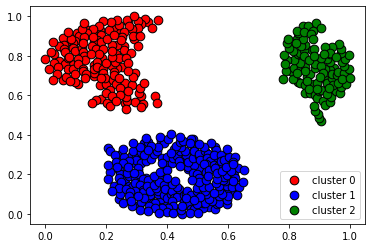

In [123]:
X = Dados('cluster.dat', dataset = 'training', norm = True)
clustersHierarchical = Hierarquico(X, 3)
hierarchicalPlot(clustersHierarchical)

&emsp;Visualmente é possivel notar que a clusterização foi ótima e os clusters estão muito bem definidos, e que o resultado da clusterização ficou identico ao do kmeans

### 2.3 Analise
&emsp;Neste tópico farei a análise do efeito da normalização.

#### 2.3.1 Normalização
&emsp; O que se espera para uma execução sem normalização, para esse método, é uma clusterização incorreta, visto que a falta de normalização da pesos diferentes as features, além disso pode-se dizer que o resultado pode ser diferente do que foi obtido no kmeans sem normalização, isso porque as métricas de separação de clusters são diferentes e, também, como os dados não estão normalizados é esperado obter um comportamento distinto. <br>
&emsp; Inicialmente irei executar o método elbow da clusterização hierarquica e ver se ira ser obtido um cotovelo bem definido:

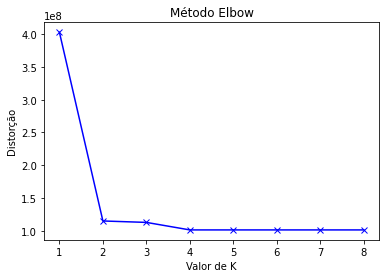

In [130]:
X2 = Dados('cluster.dat', dataset = 'training', norm = False)
elbowHierarchical(X2)

&emsp; Obtemos um cotovelo bem forte em k = 2, agora vou executar a clusterização hierarquica e fazer seu plot para observarmos a saida:

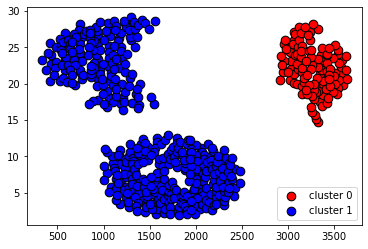

In [125]:
X2 = Dados('cluster.dat', dataset = 'training', norm = False)
clustersHierarchical2 = Hierarquico(X2, 2)
hierarchicalPlot(clustersHierarchical2)

&emsp; Pode-se dizer que para k = 2 a clusterização foi bem coerente, mas antes de executarmos para k = 3, vamos tentar entender porque o método elbow nos disse que o número ótimo de clusters é k = 2. <br>
&emsp; Vamos plotar novamente o gráfico acima, mas agora vou mexer na escala do gráfico, irei colocar o eixo y na mesma escala do eixo x, mas sem alterar a escala dos dados: 

In [133]:
def hierarchicalPlot_2(clusters):
    cores = ['r','b','g','c','m','y']
    plt. ylim(1, 1500)
    for key in clusters:
        cluster = np.array(clusters[key])
        plt.scatter(cluster[:,0],cluster[:,1], s=75, color=cores[key],  edgecolor='k', label='cluster '+str(key+1))
    plt.legend(scatterpoints=1)
    plt.show()

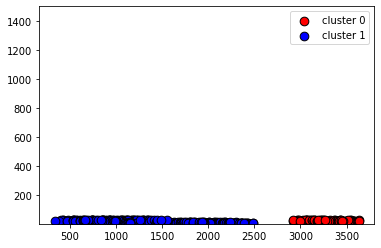

In [127]:
hierarchicalPlot_2(clustersHierarchical2)

&emsp; Olhando dessa perspectiva fica bem evidente porque o método elbow nos disse que o número ideal de clusters foi de k = 2. Agora vou executar, os dados sem normalização, para k = 3 e analisar o resultado:

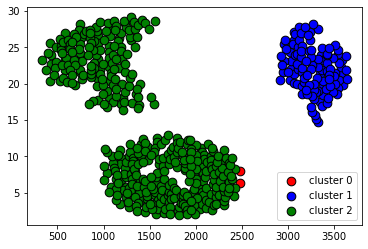

In [128]:
clustersHierarchical2 = Hierarquico(X2, 3)
hierarchicalPlot(clustersHierarchical2)

&emsp; É possível notar que para k = 3 a clusterização ficou bem esquisita, mas isso já era esperado visto que os dados não estão normalizado, mas agora vamos analisar algumas peculiaridades: <br>

1. Por que um dos clusters é extremamente pequeno e desproporcional aos outros?<br>
<p style='text-align: justify;'> A resposta para essa questão é que o número ideal de clusters, para os dados não normalizados, não é 3. No método hierarquico vamos agrupando os clusters baseando-se em distancias, quando forçamos o algoritmo parar em k = 3 impedimos que aquele pequeno cluster sofresse um merge com o cluster mais próximo, assim impedindo que obtivessemos uma melhor clusterização, isso evidencia a importancia de executar um bom método para se obter o k ideal.</p>

2. Por que a execução dos dados não normalizados, para k = 3, ficou diferente do kmeans?<br>
<p style='text-align: justify;'> Isso acontece porque as métricas de divisão dos clusters são diferentes, no kmeans os clusters são definidos baseados nas distancias dos centroides, ja no hierarquico definimos baseado na distancia entre os clusters, assim como a clusterização está sendo feita para um k incorreto e sobre dados não normalizados essas métricas tem um impacto muito grande.</p>

### 2.4 Aplicação do conjunto de testes
<p style="text-align: justify;">
    &emsp; Agora chegou o momento de classificar os pontos do conjunto de testes, para melhor organização irei fazer novamente o treinamento (utilizando o conjunto de treinamento) com as funções ja prontas e a após isso vou definir o cluster a qual os pontos do conjunto de teste pertencem baseando-se na distancia entre o ponto analisado e o ponto médio do cluster.
</p>

#### 2.4.1 Treinamento
&emsp; O Treinamento é simples, basta executar as funções já prontas, lembrando que, baseado em toda analise anterior, aplicaremos o agglomerative hierarchical clustering até que obtemos 3  clusters:

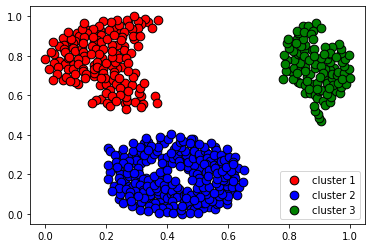

In [217]:
TrainingDataset_H = Dados('cluster.dat', dataset = 'training', norm = True)
clustersTreino_H = Hierarquico(TrainingDataset_H, 3)
hierarchicalPlot(clustersTreino_H)